## Predicción de insuficiencia cardíaca

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score
import io
import requests
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
# df = pd.read_csv('heart_failure.csv')

url = 'https://raw.githubusercontent.com/casasmgb/curso-ml/main/01-section/regression/heart_failure.csv'
data = requests.get(url).content
df = pd.read_csv(io.StringIO(data.decode('utf-8')))

In [3]:
df.head()

,edad,anemia,creatinina_fosfoquinasa,diabetes,fraccion_eyeccion,presion_sanguinea_alta,plaquetas,creatinina_serica,sodio_serico,sexo,tabaquismo,tiempo,EVENTO_MUERTE
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   edad                     299 non-null    float64
 1   anemia                   299 non-null    int64  
 2   creatinina_fosfoquinasa  299 non-null    int64  
 3   diabetes                 299 non-null    int64  
 4   fraccion_eyeccion        299 non-null    int64  
 5   presion_sanguinea_alta   299 non-null    int64  
 6   plaquetas                299 non-null    float64
 7   creatinina_serica        299 non-null    float64
 8   sodio_serico             299 non-null    int64  
 9   sexo                     299 non-null    int64  
 10  tabaquismo               299 non-null    int64  
 11  tiempo                   299 non-null    int64  
 12  EVENTO_MUERTE            299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


Verificamos que no existan nulos o NaN

In [5]:
print('null value\n',df.isnull().sum(axis=0),'\n')
print('NaN value\n',df.isna().sum(axis=0),'\n')

null value
 edad                       0
anemia                     0
creatinina_fosfoquinasa    0
diabetes                   0
fraccion_eyeccion          0
presion_sanguinea_alta     0
plaquetas                  0
creatinina_serica          0
sodio_serico               0
sexo                       0
tabaquismo                 0
tiempo                     0
EVENTO_MUERTE              0
dtype: int64 

NaN value
 edad                       0
anemia                     0
creatinina_fosfoquinasa    0
diabetes                   0
fraccion_eyeccion          0
presion_sanguinea_alta     0
plaquetas                  0
creatinina_serica          0
sodio_serico               0
sexo                       0
tabaquismo                 0
tiempo                     0
EVENTO_MUERTE              0
dtype: int64 



Correlacion de edad y el evento de muerte

In [6]:
df_corr = df[["edad", "EVENTO_MUERTE"]]
df_corr.corr()

,edad,EVENTO_MUERTE
edad,1.000000,0.253729
EVENTO_MUERTE,0.253729,1.000000


In [7]:
df_corr = df[["anemia", "EVENTO_MUERTE"]]
df_corr.corr()

,anemia,EVENTO_MUERTE
anemia,1.00000,0.06627
EVENTO_MUERTE,0.06627,1.00000


In [8]:
df_corr = df[["creatinina_fosfoquinasa", "EVENTO_MUERTE"]]
df_corr.corr()

,creatinina_fosfoquinasa,EVENTO_MUERTE
creatinina_fosfoquinasa,1.000000,0.062728
EVENTO_MUERTE,0.062728,1.000000


## Correlacion de todo el dataset

|Greys|Purples|Blues|Greens|Oranges|Reds|YlOrBr|YlOrRd|OrRd|PuRd|RdPu|BuPu|GnBu|PuBu|YlGnBu|PuBuGn|BuGn|YlGn|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|

https://matplotlib.org/stable/tutorials/colors/colormaps.html

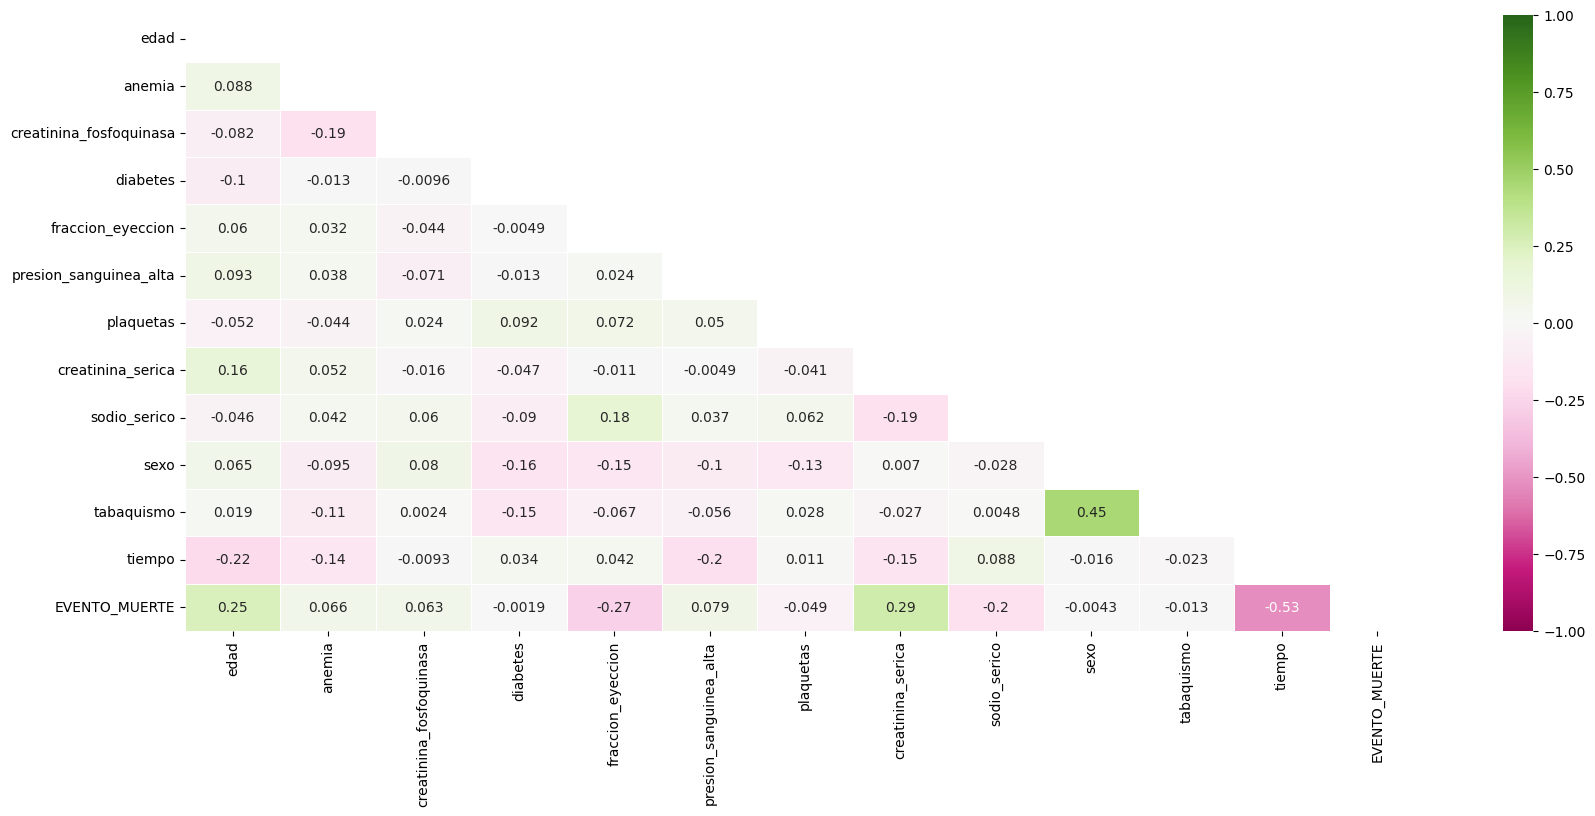

In [9]:
corr_df = df.corr()
mask = np.triu(np.ones_like(corr_df, dtype=np.bool_))

plt.figure(figsize=(20,8))

sns.heatmap(corr_df,
            vmin=-1, vmax=1,
            annot=True,
            cmap='PiYG',
            mask=mask,
            linewidths=.5)
plt.show()

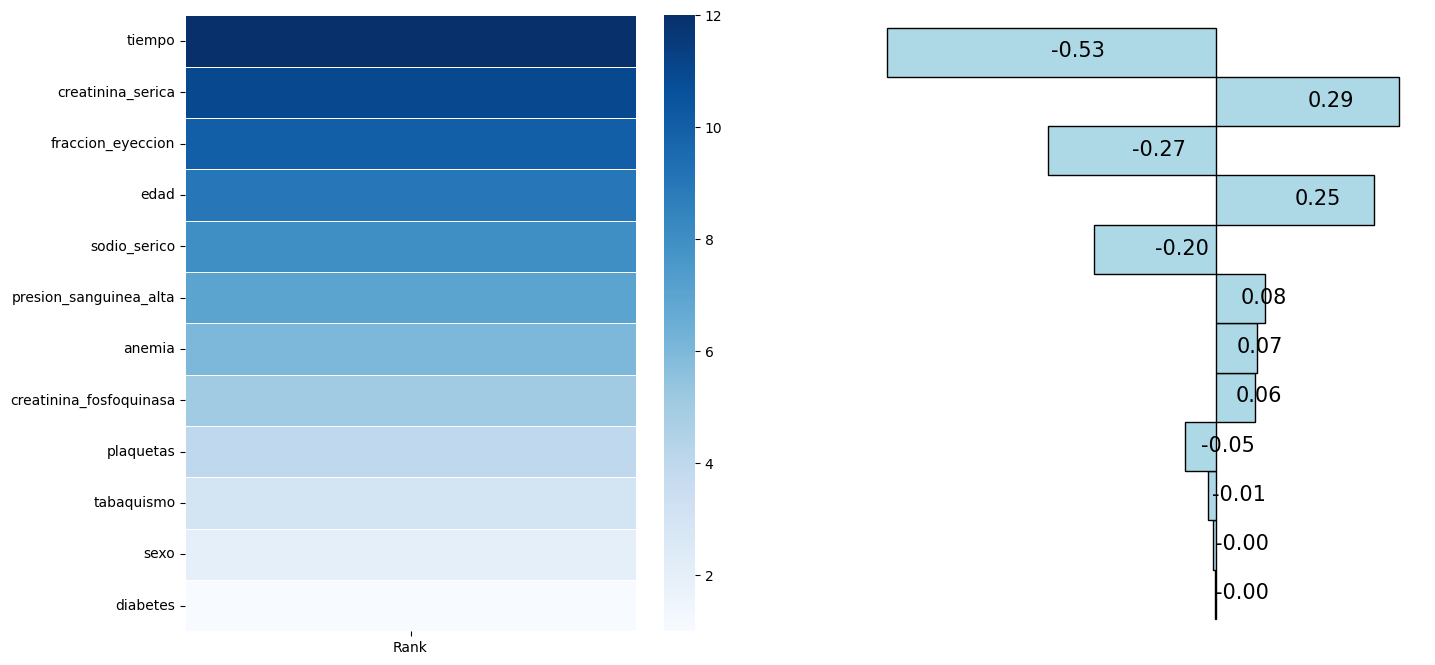

In [10]:
# Creat Ranking correlation table
corr_death=corr_df[['EVENTO_MUERTE']][0:-1]
corr_death['ABS_DEATH_EVENT']=abs(corr_death.values)
corr_death['Rank']=corr_death['ABS_DEATH_EVENT'].rank()
corr_death=corr_death.sort_values(by='Rank', ascending=False)
corr_death

#Creat correlation ranking charts
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
sns.heatmap(corr_death[['Rank']],
           vmin=corr_death[['Rank']].min(), vmax=corr_death[['Rank']].max(),
            cmap='Blues',
            linewidths=.5)
plt.subplot(1,2,2)
corr_death.sort_values(by='Rank', ascending=True)['EVENTO_MUERTE'].plot(kind='barh', color='LightBlue', width=1, edgecolor='black')
for i, value in enumerate(corr_death.sort_values(by='Rank', ascending=True)['EVENTO_MUERTE']):
    text="{:.2f}".format(value)
    plt.annotate(text=text, xy=(value/2, i-0.1), fontsize=15)
        
plt.axis('off')

plt.show()

# Separado de datos de entrenamiento y prueba

In [11]:
x = df['tiempo'].to_numpy()
print (x)


x = df['tiempo'].to_numpy().reshape(-1, 1)
print (x)

y = df['EVENTO_MUERTE'].to_numpy()

[  4   6   7   7   8   8  10  10  10  10  10  10  11  11  12  13  14  14
  15  15  16  20  20  22  23  23  24  26  26  26  27  28  28  29  29  30
  30  30  30  30  31  32  33  33  33  35  38  40  41  42  43  43  43  44
  45  50  54  54  55  59  60  60  60  61  63  64  65  65  66  67  68  71
  72  72  73  73  74  74  74  74  75  76  77  78  78  79  79  79  79  79
  80  80  82  82  83  83  83  85  85  86  87  87  87  87  87  88  88  88
  88  88  90  90  90  90  91  91  94  94  94  95  95  95  95  95  96  97
 100 104 104 105 106 107 107 107 107 107 107 108 108 108 109 109 109 110
 111 112 112 113 113 115 115 117 118 119 120 120 120 120 121 121 121 121
 123 126 129 130 134 135 140 145 145 146 146 146 146 146 147 147 147 147
 148 150 154 162 170 171 172 172 172 174 174 174 175 180 180 180 185 186
 186 186 186 186 186 187 187 187 187 187 187 187 188 192 192 193 194 195
 196 196 197 197 198 200 201 201 205 205 205 206 207 207 207 208 209 209
 209 209 209 210 210 211 212 212 212 213 213 213 21

In [12]:
x = df['tiempo'].to_numpy().reshape(-1, 1)
y = df['EVENTO_MUERTE'].to_numpy()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=None)

In [13]:
x_train[5], x_test[5], y_train[5], y_test[5]

(array([201]), array([80]), 0, 0)

In [14]:
print('porcentaje de datos para x\n')
print((x_train.shape[0] * 100) / x.shape[0])
print((x_test.shape[0] * 100) / x.shape[0])

print('\nporcentaje de datos para y\n')
print((y_train.shape[0] * 100) / y.shape[0])
print((y_test.shape[0] * 100) / y.shape[0])

porcentaje de datos para x

69.89966555183946
30.100334448160535

porcentaje de datos para y

69.89966555183946
30.100334448160535


## Identificar la mejor cantidad de columnas

['tiempo', 'creatinina_serica']
Precision:  88.33% 

['tiempo', 'creatinina_serica', 'fraccion_eyeccion']
Precision:  90.00% 

['tiempo', 'creatinina_serica', 'fraccion_eyeccion', 'edad']
Precision:  88.33% 

['tiempo', 'creatinina_serica', 'fraccion_eyeccion', 'edad', 'sodio_serico']
Precision:  90.00% 

['tiempo', 'creatinina_serica', 'fraccion_eyeccion', 'edad', 'sodio_serico', 'presion_sanguinea_alta']
Precision:  88.33% 

['tiempo', 'creatinina_serica', 'fraccion_eyeccion', 'edad', 'sodio_serico', 'presion_sanguinea_alta', 'anemia']
Precision:  88.33% 

['tiempo', 'creatinina_serica', 'fraccion_eyeccion', 'edad', 'sodio_serico', 'presion_sanguinea_alta', 'anemia', 'creatinina_fosfoquinasa']
Precision:  86.67% 

['tiempo', 'creatinina_serica', 'fraccion_eyeccion', 'edad', 'sodio_serico', 'presion_sanguinea_alta', 'anemia', 'creatinina_fosfoquinasa', 'plaquetas']
Precision:  86.67% 

['tiempo', 'creatinina_serica', 'fraccion_eyeccion', 'edad', 'sodio_serico', 'presion_sanguinea_alta

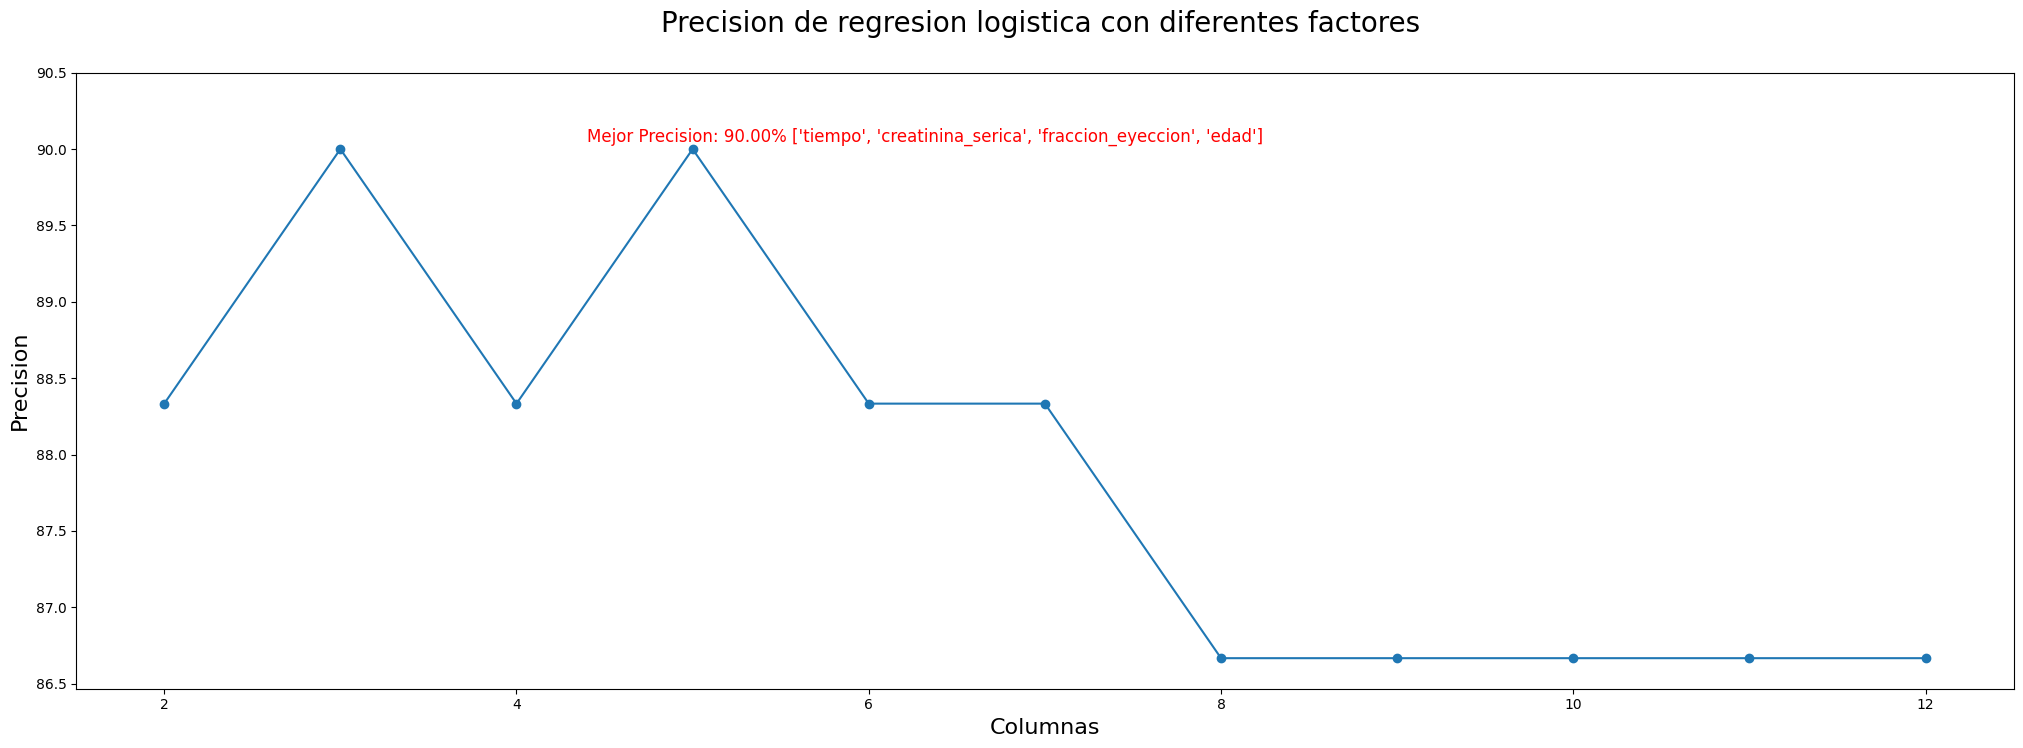

In [15]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

columns=list(corr_death.index)
n_columns=len(columns)
transform = preprocessing.StandardScaler()
lr=LogisticRegression()
acc_table=pd.DataFrame(columns=['Columnas','Precision'])

heart_df = df

for i in range(2,n_columns+1):
    end=i
    features=columns[0:end]
    print(features)
    x=heart_df[features]
    y=heart_df['EVENTO_MUERTE']
    x=transform.fit_transform(x)
    x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.2, random_state=2)
    lr.fit(x_train, y_train)
    y_hat=lr.predict(x_test)
    acc=accuracy_score(y_test, y_hat)*100
    
    print('Precision: ','{:.2f}%'.format(acc), '\n')
    row=pd.DataFrame([[i, acc.tolist()]], columns=['Columnas','Precision'])
    acc_table=pd.concat([acc_table, row])
    
best=acc_table.sort_values(by='Precision', ascending=False)['Columnas'].iloc[0]
print("Mejor numero de columnas: ", best)
best_acc=acc_table.sort_values(by='Precision', ascending=False)['Precision'].iloc[0]
ymin=acc_table.sort_values(by='Precision', ascending=False)['Precision'].iloc[-1]

acc_table.set_index('Columnas').plot(kind='line',
                                   figsize=(25,8),
                                   marker='o', 
                                   legend=False)
plt.annotate(text='Mejor Precision: '+'{:.2f}%'.format(best_acc)+' '+str(columns[0:best+1]),
             xy=(best-0.6, best_acc+0.05),
             fontsize=12,
             color='red')

plt.title('Precision de regresion logistica con diferentes factores \n', fontsize=20)
plt.xlabel('Columnas', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.ylim(ymin-0.2, best_acc+0.5)


plt.show()

## Regresion Logistica  con las mejores columas

['tiempo', 'creatinina_serica', 'fraccion_eyeccion']


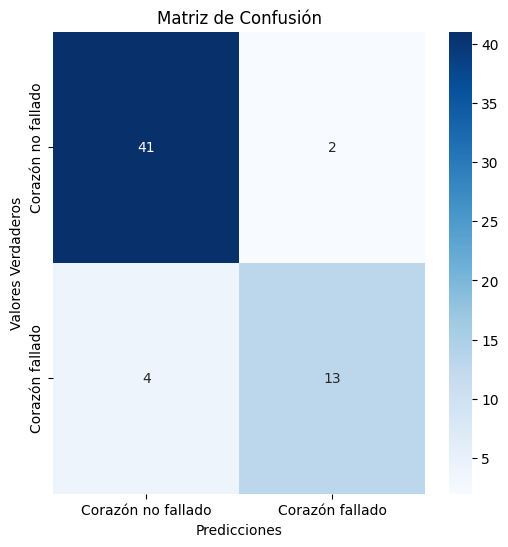

Accuracy:  90.00% 



In [16]:
best_features=columns[0:best]
print(best_features)
best_x=heart_df[best_features]
y=heart_df['EVENTO_MUERTE']
best_x=transform.fit_transform(best_x)
x_train, x_test, y_train, y_test=train_test_split(best_x, y, test_size=0.2, random_state=2)
lr.fit(x_train, y_train)
best_y_hat=lr.predict(x_test)

conf_matrix = confusion_matrix(y_test, best_y_hat)
class_names = ['Corazón no fallado', 'Corazón fallado']

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicciones', fontsize=10)
plt.ylabel('Valores Verdaderos', fontsize=10)
plt.title('Matriz de Confusión')
plt.show()
lr_best_acc=accuracy_score(y_test, best_y_hat)*100
    
print('Accuracy: ','{:.2f}%'.format(lr_best_acc), '\n')

## Modelo SVR


['tiempo', 'creatinina_serica']
Precision:  86.67% 

['tiempo', 'creatinina_serica', 'fraccion_eyeccion']
Precision:  91.67% 

['tiempo', 'creatinina_serica', 'fraccion_eyeccion', 'edad']
Precision:  88.33% 

['tiempo', 'creatinina_serica', 'fraccion_eyeccion', 'edad', 'sodio_serico']
Precision:  86.67% 

['tiempo', 'creatinina_serica', 'fraccion_eyeccion', 'edad', 'sodio_serico', 'presion_sanguinea_alta']
Precision:  88.33% 

['tiempo', 'creatinina_serica', 'fraccion_eyeccion', 'edad', 'sodio_serico', 'presion_sanguinea_alta', 'anemia']
Precision:  88.33% 

['tiempo', 'creatinina_serica', 'fraccion_eyeccion', 'edad', 'sodio_serico', 'presion_sanguinea_alta', 'anemia', 'creatinina_fosfoquinasa']
Precision:  86.67% 

['tiempo', 'creatinina_serica', 'fraccion_eyeccion', 'edad', 'sodio_serico', 'presion_sanguinea_alta', 'anemia', 'creatinina_fosfoquinasa', 'plaquetas']
Precision:  85.00% 

['tiempo', 'creatinina_serica', 'fraccion_eyeccion', 'edad', 'sodio_serico', 'presion_sanguinea_alta

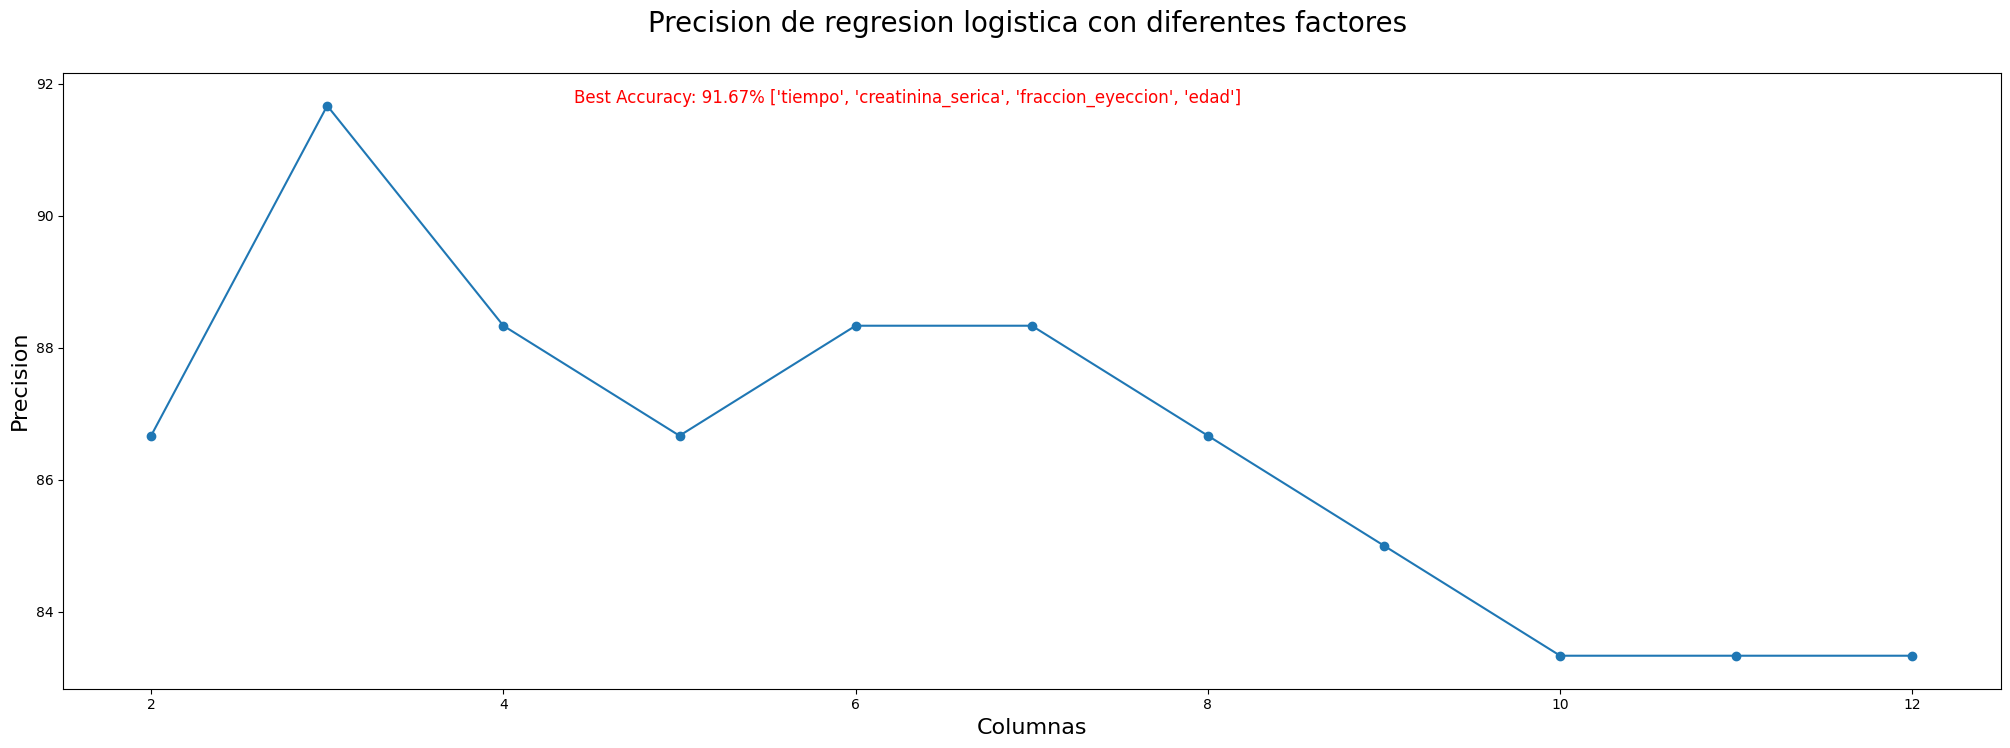

In [17]:
columns=list(corr_death.index)
n_columns=len(columns)
transform = preprocessing.StandardScaler()
svm=SVC()
acc_table=pd.DataFrame(columns=['Columnas','Precision'])

for i in range(2,n_columns+1):
    end=i
    features=columns[0:end]
    print(features)
    x=heart_df[features]
    y=heart_df['EVENTO_MUERTE']
    x=transform.fit_transform(x)
    x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.2, random_state=2)
    svm.fit(x_train, y_train)
    y_hat=svm.predict(x_test)
    acc=accuracy_score(y_test, y_hat)*100
    
    print('Precision: ','{:.2f}%'.format(acc), '\n')
    row=pd.DataFrame([[i, acc.tolist()]], columns=['Columnas','Precision'])
    acc_table=pd.concat([acc_table, row])
    
acc_table

best=acc_table.sort_values(by='Precision', ascending=False)['Columnas'].iloc[0]
print("Best number of columns: ", best)
best_acc=acc_table.sort_values(by='Precision', ascending=False)['Precision'].iloc[0]
ymin=acc_table.sort_values(by='Precision', ascending=False)['Precision'].iloc[-1]

acc_table.set_index('Columnas').plot(kind='line',
                                   figsize=(25,8),
                                   marker='o', 
                                   legend=False)
plt.annotate(text='Best Accuracy: '+'{:.2f}%'.format(best_acc)+' '+str(columns[0:best+1]),
             xy=(best-0.6, best_acc+0.05),
             fontsize=12,
             color='red')

plt.title('Precision de regresion logistica con diferentes factores \n', fontsize=20)
plt.xlabel('Columnas', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.ylim(ymin-0.5, best_acc+0.5)

plt.show()

['tiempo', 'creatinina_serica', 'fraccion_eyeccion']


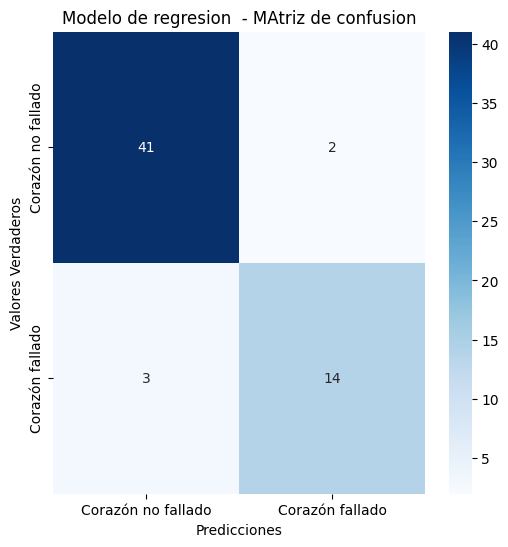

Accuracy:  91.67% 



In [18]:
best_features=columns[0:best]
print(best_features)
best_x=heart_df[best_features]
y=heart_df['EVENTO_MUERTE']
best_x=transform.fit_transform(best_x)


x_train, x_test, y_train, y_test=train_test_split(best_x, y, test_size=0.2, random_state=2)


svm.fit(x_train, y_train)
best_y_hat=svm.predict(x_test)





conf_matrix = confusion_matrix(y_test, best_y_hat)
class_names = ['Corazón no fallado', 'Corazón fallado']

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicciones', fontsize=10)
plt.ylabel('Valores Verdaderos', fontsize=10)
plt.title('Modelo de regresion  - MAtriz de confusion')
plt.show()

svm_best_acc=accuracy_score(y_test, best_y_hat)*100
    
print('Accuracy: ','{:.2f}%'.format(svm_best_acc), '\n')

## Prediccion

In [19]:
y_pred = svm.predict(x_test)

print ('Datos prediccion')
print(y_pred.round().astype('int'))
print('\n')
print ('Datos prueba')
print(y_test)

Datos prediccion
[0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0
 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 1 1 0 1 0 0 0 0]


Datos prueba
179    0
221    0
226    0
7      1
173    0
30     1
183    1
181    1
271    0
141    0
13     1
272    0
35     1
270    0
77     0
267    0
206    0
94     0
91     0
214    0
3      1
104    0
29     1
170    0
134    0
41     1
251    0
288    0
133    0
160    0
152    0
66     1
243    0
237    0
89     0
273    0
157    0
103    0
126    1
222    0
11     1
224    0
164    1
127    0
174    0
74     1
188    0
239    0
283    0
156    0
131    0
99     0
10     1
84     1
142    0
65     1
118    0
282    0
109    0
205    0
Name: EVENTO_MUERTE, dtype: int64
